## Predicting uncertainty with (deep) neural networks

**Experiment**: Keras implementation of the original experiment (implemented in Pytorch) using two different tensors (y and sigma) for target

**NOTE**: This notebook has been adapted to ease its comprenhesion : https://github.com/sthorn/deep-learning-explorations/blob/master/predicting-uncertainty.ipynb*

### Imports 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
import statistics as stat
import tensorflow as tf

%matplotlib inline

### Generate some random data

In [13]:
# Generate some linearly related data
np.random.seed(2019)

n_samples = 10000
x = np.random.random(n_samples)

sin_ = 0.4 * np.sin(x*4*np.pi)
eps = np.random.normal(scale=1.0, size=n_samples) * sin_ # noise
y_1 = 2*x + 1 
y = y_1 + eps # linear data with noise

### Prepare data for training

In [14]:
# Add in column of dummy zeros to represent sigma 
sigma = np.zeros(y.size)
y = np.stack([y, sigma], axis=1)

In [15]:
# Reshape x for PyTorch
#x = x.reshape(10000, 1)
x = x.reshape(x.size, 1)

In [16]:
# Split into training and validation sets
n_validation = 500
x_val, x = x[:n_validation], x[n_validation:]
y_val, y = y[:n_validation], y[n_validation:]

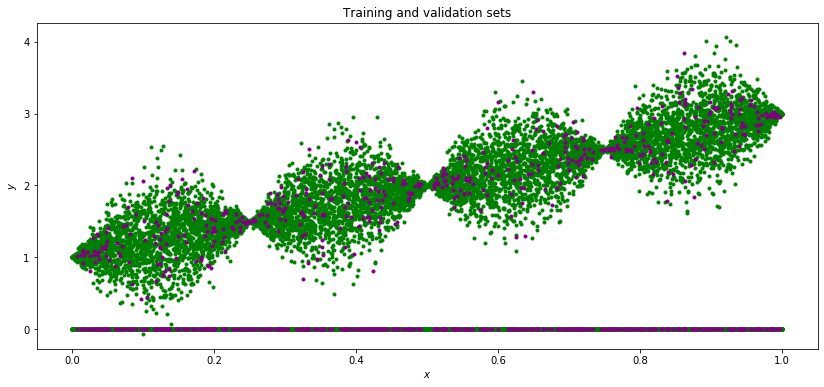

In [17]:
# Plot the data
plt.figure(figsize=(14,6))
plt.title('Training and validation sets')
plt.plot(x, y, '.', color= 'green')
plt.plot(x_val, y_val, '.', color='purple')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [129]:
# Convert x and y to PyTorch Variables on the GPU
x_t = tf.convert_to_tensor(x, np.float32)
y_t = tf.convert_to_tensor(y[:,[0]], np.float32)
sigma_t = tf.convert_to_tensor(y[:,[1]], np.float32)

In [43]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x_t.shape, y_t.shape, sigma_t.shape

(TensorShape([Dimension(9500), Dimension(1)]),
 TensorShape([Dimension(9500), Dimension(1)]),
 TensorShape([Dimension(9500), Dimension(1)]))

In [25]:
y_t[:,0]

<tf.Tensor 'strided_slice_2:0' shape=(9500,) dtype=float32>

## Experiment 

### Create a simple network 

In [84]:
# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
n_inputs = 1
n_outputs = 2
n_hidden = 1000

def get_model01():
    in_x = tf.keras.Input(
        shape=(1,),
        name="x"
    )
    f1 = tf.keras.layers.Dense(
        n_hidden,
        name="hidden",
        activation=tf.keras.activations.relu
    )(in_x)
    out_y = tf.keras.layers.Dense(
        1,
        name="y",
        activation=tf.keras.activations.linear
    )(f1)
    out_var = tf.keras.layers.Dense(
        1,
        name="sigma",
        activation=tf.keras.activations.linear
    )(f1)
    return tf.keras.Model(inputs=[in_x], outputs=[out_y, out_var], name="model01")

In [85]:
model_2 = get_model01()
model_2.summary()

Model: "model01"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
hidden (Dense)                  (None, 1000)         2000        x[0][0]                          
__________________________________________________________________________________________________
y (Dense)                       (None, 1)            1001        hidden[0][0]                     
__________________________________________________________________________________________________
sigma (Dense)                   (None, 1)            1001        hidden[0][0]                     
Total params: 4,002
Trainable params: 4,002
Non-trainable params: 0
________________________

### Custom loss function
This is where the magic happens.

In [170]:
from keras import losses

def sigma_loss_error(y_true, y_pred):
    # Estimate target value for variance (sigma^2) with (y_pred - y)**2
    #
    diff_var = tf.Variable((y_pred - y_true)**2)
    #y_true = diff_var  # compute variance <------------------- HERE is the problem !! Cannot update the variable...
    #with tf.control_dependencies([y_true]):
    return  losses.mean_squared_error(y_pred, y_true)

In [171]:
lossWeights={'y':0.5,
          'sigma':0.5  
        }
custom_losses ={'y':'mean_squared_error',
          'sigma':sigma_loss_error    
        }

model_2.compile(loss=custom_losses, loss_weights= lossWeights, target_tensors=[y_t, sigma_t], optimizer='adam')

### Training loop 
We train this simple model with batch size equal to the whole dataset.

In [172]:
steps_=50
n_epochs = int(10000/steps_)
model_2.fit(x_t, epochs=n_epochs, batch_size=32, verbose=1, steps_per_epoch=steps_)

Epoch 1/200
50/50 [==============================] - 1s 19ms/step - loss: 0.0411 - y_loss: 0.0822 - sigma_loss: 1.8822e-05
Epoch 2/200
50/50 [==============================] - 1s 14ms/step - loss: 0.0411 - y_loss: 0.0821 - sigma_loss: 2.3085e-07
Epoch 3/200
50/50 [==============================] - 1s 14ms/step - loss: 0.0411 - y_loss: 0.0821 - sigma_loss: 4.1110e-09
Epoch 4/200
50/50 [==============================] - 1s 14ms/step - loss: 0.0411 - y_loss: 0.0821 - sigma_loss: 2.4441e-09
Epoch 5/200
50/50 [==============================] - 1s 14ms/step - loss: 0.0411 - y_loss: 0.0821 - sigma_loss: 2.3383e-09
Epoch 6/200
50/50 [==============================] - 1s 14ms/step - loss: 0.0411 - y_loss: 0.0821 - sigma_loss: 2.2529e-09
Epoch 7/200
50/50 [==============================] - 1s 14ms/step - loss: 0.0411 - y_loss: 0.0821 - sigma_loss: 2.1626e-09
Epoch 8/200
50/50 [==============================] - 1s 14ms/step - loss: 0.0411 - y_loss: 0.0821 - sigma_loss: 2.0888e-09
Epoch 9/200
50/5

### Get predictions for validation set 

In [ ]:
# Get predicted y and sigma for validation set
x_val_t =  tf.convert_to_tensor(x_val, np.float32)
pred_1 = model_2.predict(x_val_t, steps=1)

len(pred_1), x_val_t.shape

In [134]:
len(pred_1[1])

500

In [135]:
# prediction of the response variables
y_pred_1 = pred_1[0]
sigma_pred_1 = pred_1[1]

### Plot results

C:\Users\yolan\Anaconda3\envs\deep_learning_keras\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  import sys


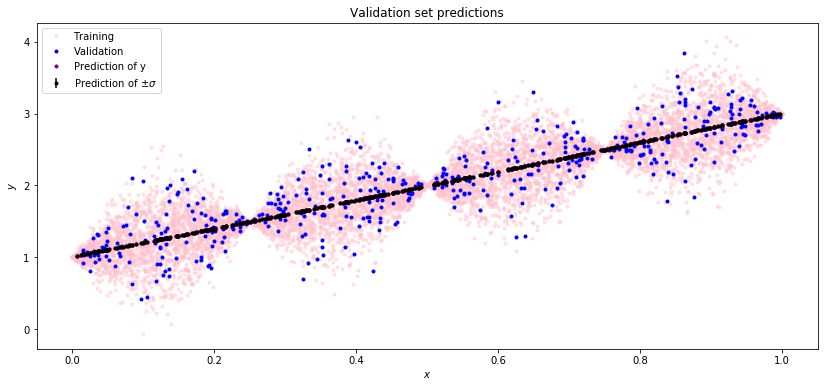

In [136]:
# Plot predictions and their errors
fig, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(x, y[:,0], '.', alpha=0.4, color='pink')
ax1.plot(x_val, y_val[:,0], '.', color='blue')
ax1.plot(x_val, y_pred_1, '.', color='purple')
ax1.errorbar(x_val, y_pred_1, yerr=sigma_pred_1, fmt='.k');

ax1.set_xlabel(r'$x$');
ax1.set_ylabel(r'$y$');
ax1.set_title('Validation set predictions');
ax1.legend([r'Training', r'Validation', r'Prediction of y','Prediction of $\pm \sigma$'], loc='upper left', );

C:\Users\yolan\Anaconda3\envs\deep_learning_keras\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  This is separate from the ipykernel package so we can avoid doing imports until


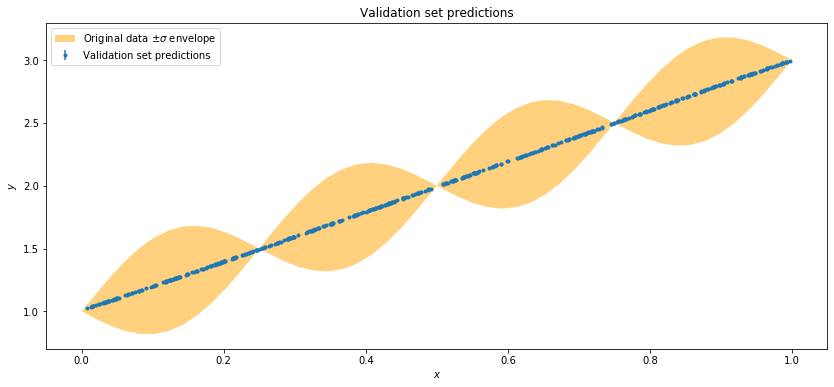

In [138]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
plt.errorbar(x_val, y_pred_1, yerr=sigma_pred_1, fmt='.');

# One standard-deviation envelope
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );